In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy import spatial
from scipy import stats
from pprint import pprint

/home/tg/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
blob_file = "../data/hw5_blob.csv"
circle_file = "../data/hw5_circle.csv"


In [3]:
def load_points(f_name):
    with open(f_name) as f:
        res = []
        for l in f:
            x,y = l.split(",")
            res.append([float(x), float(y)])
        return np.array(res)

blobs = load_points(blob_file)
circles = load_points(circle_file)

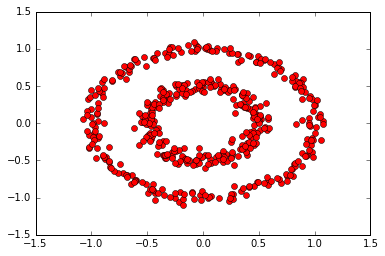

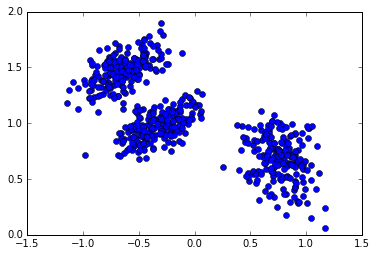

In [4]:
plt.plot(*zip(*circles), marker='o', color='r', ls='')
plt.show()

plt.plot(*zip(*blobs), marker='o', color='b', ls='')
plt.show()

In [5]:
def k_means(k, pts, get_indices=False, silent=True, tol=1e-5):
    N = len(pts)
    assert k <= N
    print("K=%d, N=%d" % (k, N))
    # pick random k points
    pos = set()
    while len(pos) < k:
        r = np.random.randint(N)
        pos.add(r)
    centroids = []
    for p in pos:
        centroids.append(tuple(pts[p]))
   
    change = float('inf')
    conv_tol = 1e-5
    itr, max_iters = 0, 100
    while change > tol and itr < max_iters:
        itr += 1
        # assign cluster to each point
        asgn = {}
        indices = {}
        for ct in centroids:
            asgn[ct] = []
            indices[ct] = []
        for idx, pt in enumerate(pts):
            mindist = float('inf')
            a = None
            for ct in centroids:
                dist = spatial.distance.cdist([ct], [pt])
                if dist < mindist:
                    mindist = dist
                    a = ct
            asgn[a].append(pt)
            indices[a].append(idx)

        # compute means of each cluster
        oldcentr = centroids
        centroids = []
        for ct, cluster in asgn.items():
            centroids.append(tuple(np.array(cluster).mean(axis=0)))
        dist_matrix = spatial.distance.cdist(oldcentr, centroids) 
        # has distance between each pair of {new, old} centroids
        # need the diagonal values
        change = dist_matrix.trace()
        if not silent:
            print("Movement in centroids", change)
    return indices if get_indices else asgn


K=2, N=500
K=3, N=500
K=5, N=500
K=2, N=600
K=3, N=600
K=5, N=600


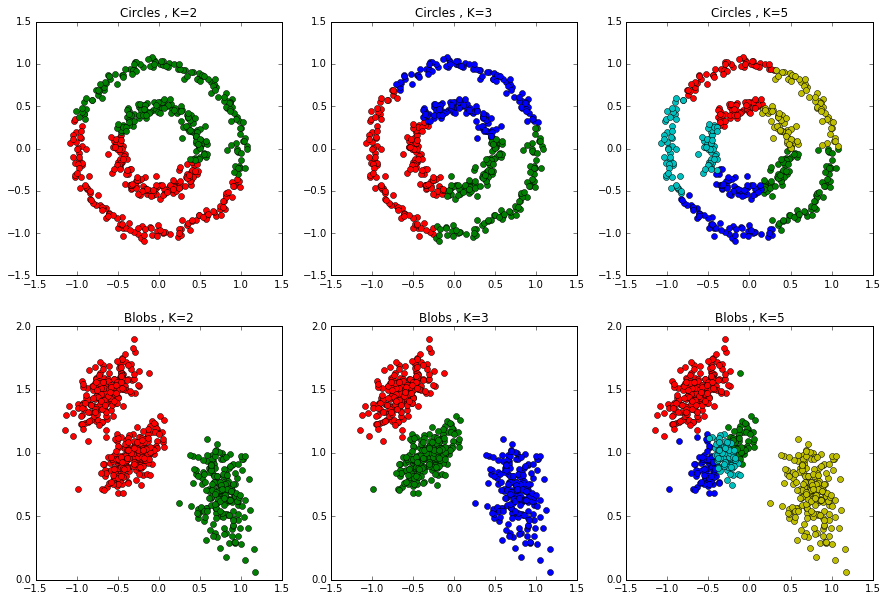

In [6]:
colors = ['r', 'g', 'b', 'y', 'c', 'k']
plt.figure(1, figsize=(15, 10))

ks = {2,3,5}
dss = {'Blobs': blobs, 'Circles': circles}
j = 1
for title, ds in dss.items():
    for k in ks:
        clstrs = k_means(k, ds)
        plt.subplot(2, 3, j)
        i = 0
        for cnt, cpts in clstrs.items():
            plt.plot(*zip(*cpts), marker='o', color=colors[i], ls='')
            i += 1
        plt.title("%s , K=%d" % (title, k))
        j += 1
        
plt.show()

# Kernel

## Feature Mapping

K=2, N=500


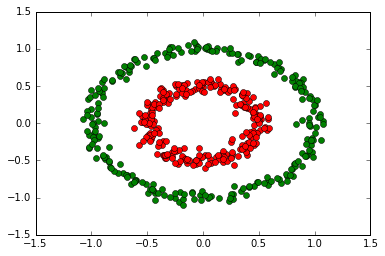

In [7]:
center = [0.0, 0.0]
newdim = sp.spatial.distance.cdist([center], circles).transpose()
clusters = k_means(2, newdim, get_indices=True)
i = 0
for cnt, cpts in clusters.items():
    cpts = map(lambda x: circles[x], cpts)
    plt.plot(*zip(*cpts), marker='o', color=colors[i], ls='')
    i += 1
plt.show()

## Kernel K Means

Kernel used :
 1 - (radius of x1) / (radius of x2)
 
 It ensures that the smaller radius goes to numerator and larger radius goes to denominator - for symmetry and bounding

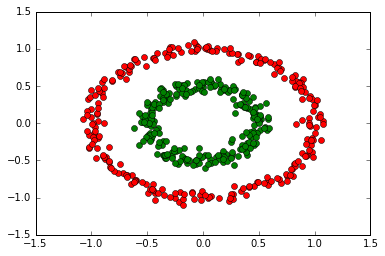

In [8]:
class KernelKMeans(object):
        
    def kernel_matrix(self, data, kernel_func):
        ''' Computes kernel matrix
        : params:
            data - data points
            kernel_func - kernel function
        :returns: nxn matrix
        '''
        n = data.shape[0]
        K = np.zeros((n,n), dtype=float)
        for i in range(n):
            for j in range(n):
                K[i,j] = kernel_func(data[i], data[j])
        return K

    def cluster(self, X, k, kernel_func, max_itr=100, tol=1e-3):
        '''
        Clusters the points
        :params:
            X - data points
            k - number of clusters
            kernel_func - kernel function that outputs smaller values for points in same cluster
        :returns: Nx1 vector of assignments
        '''
        # N
        N = X.shape[0]
        # NxN matrix from kernel funnction element wise
        K = self.kernel_matrix(X, kernel_func)
        # equal weightage to all
        cluster_weights = np.ones(N)        
        # Assignments : random assignments to begin with
        A = np.random.randint(k, size=N)

        for it in xrange(max_itr): # stuck up between 2 local minimas, abort after maxiter
            # N x k matrix that stores distance between every point and cluster center
            dist = self.compute_dist(K, k, A, sw=cluster_weights)
            oldA, A = A, dist.argmin(axis=1)
            # Check if it is conveged
            n_same = np.sum(np.abs(A - oldA) == 0)
            if 1 - float(n_same) / N < tol:
                print "Converged at iteration:", it + 1
                break
        return A

    def compute_dist(self, K, k, A, sw):
        """
        Computes Nxk distance matrix using kernel matrix
        : params:
            K - NxN kernel Matrix
            k - number of clusters
            A - Nx1 Assignments
            sw - sample weights
        : returns : Nxk distance matrix
        """
        dist = np.zeros((K.shape[0], k))
        for cl in xrange(k):
            mask = A == cl
            if np.sum(mask) == 0:
                raise Error("ERROR:cluster '%d' is empty. Looks like we cant make %d clusters" % (cl, k))
            N_ = sw[mask].sum()
            KK = K[mask][:, mask] 
            dist[:, cl] +=  np.sum(np.outer(sw[mask], sw[mask]) * KK / (N_*N_))          
            dist[:, cl] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / N_
        return dist

def distance(x1, x2):
    '''Squared Eucledian distance between 2 points
    :params:
        x1 - point1
        x2 - point2
    '''
    return np.sum((x1 - x2) ** 2)

def circular_kernel(x1, x2, center=None):
    '''This kernel outputs lesser distance for the points that are from circumference
    :params:
        x1 - first point
        x2 - second point
        center - center of circle(default = origin (0,0,...))
    '''
    if center is None:
        center = np.zeros(len(x1))
    dist1 = distance(x1, center)
    dist2 = distance(x2, center)
    return 1.0 - min(dist1, dist2) / max(dist1, dist2)

clusters = KernelKMeans().cluster(circles, 2, circular_kernel)
for i in range(k):
    cpts = circles[clusters == i]
    plt.plot(*zip(*cpts), marker='o', color=colors[i], ls='')
    i += 1
plt.show()


# EM Algorithm with GMM

Convergence
48
Mean
[array([ 0.75896025,  0.67976988]), array([-0.32587521,  0.97130823]), array([-0.6394565 ,  1.47454921])]
Covar
[array([[ 0.02717058, -0.00840046],
       [-0.00840046,  0.040442  ]]), array([[ 0.03604202,  0.01464885],
       [ 0.01464885,  0.01628928]]), array([[ 0.03596253,  0.01548842],
       [ 0.01548842,  0.01936787]])]

Convergence
42
Mean
[array([ 0.75896022,  0.6797699 ]), array([-0.6394532 ,  1.47452193]), array([-0.32585358,  0.97129513])]
Covar
[array([[ 0.02717058, -0.00840047],
       [-0.00840047,  0.04044201]]), array([[ 0.03596014,  0.01548608],
       [ 0.01548608,  0.0193756 ]]), array([[ 0.03603856,  0.01465356],
       [ 0.01465356,  0.01628837]])]

Convergence
44
Mean
[array([-0.63945991,  1.47457898]), array([-0.32589899,  0.97132253]), array([ 0.75896029,  0.67976985])]
Covar
[array([[ 0.03596516,  0.01549091],
       [ 0.01549091,  0.01935944]]), array([[ 0.03604589,  0.01464367],
       [ 0.01464367,  0.01629028]]), array([[ 0.02717057, -0

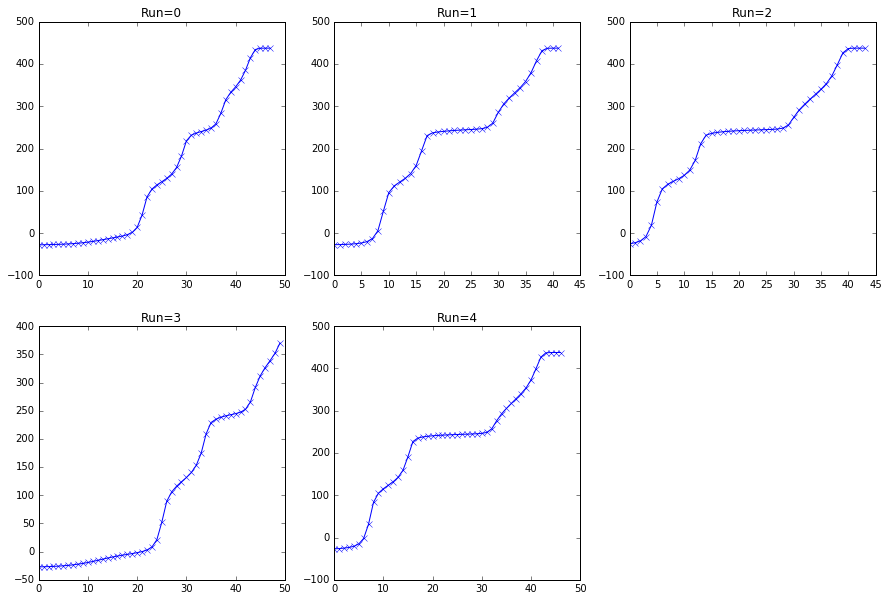


===== Best Theta =====

Mean: [array([-0.32589959,  0.9713229 ]), array([-0.63946   ,  1.47457973]), array([ 0.75896029,  0.67976985])]
Covar: [array([[ 0.03604599,  0.01464354],
       [ 0.01464354,  0.0162903 ]]), array([[ 0.03596522,  0.01549098],
       [ 0.01549098,  0.01935923]]), array([[ 0.02717057, -0.00840046],
       [-0.00840046,  0.040442  ]])]


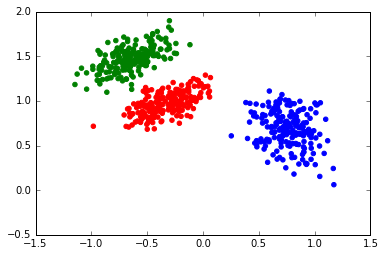

In [23]:
import math
data = blobs

# Initialize Parameters
def initialize_params(data, k):

    A = np.random.randint(k, size=data.shape[0])
    mean = []
    cov = []
    prior = []
    for c in range(k):
        mask = A == c
        cpts = data[mask]
        mean.append(np.mean(cpts, axis=0))
        cov.append(np.cov(np.array(cpts).T))
        prior.append(len(cpts)/float(len(data)))
    return {'mean': mean, 'cov': cov, 'weight': prior}

def gaussian_pdf(x, mu, covar):
    numer = np.exp(-0.5*(x - mu).T.dot(np.linalg.inv(covar)).dot(x - mu))
    denom = math.sqrt(2*math.pi*np.linalg.det(covar))   
    return numer/denom

def return_gamma(data, theta, k):
    probability = [0]*data.shape[0]
    for idx, n in enumerate(data):
        pdf = []
        for i in range(0, k):
            # P(X|N)P(N)
            temp = gaussian_pdf(n, theta['mean'][i], theta['cov'][i])
            pdf.append(temp*theta['weight'][i])
        probability[idx] = np.array(pdf)/sum(pdf)
    return np.array(probability)

def update_params(data, probability):
    prior = probability.sum(axis=0)/probability.sum()
    num_cluster = probability.shape[1]
    mean = []
    cov = []
    for i in range(0, num_cluster):
        # print probability[:, i:i+1].shape, data.shape
        numer_mean = (probability[:, i:i+1]*data).sum(axis=0)
        denom_mean = probability[:, i].sum(axis=0)
        point_mean = numer_mean/denom_mean
        mean.append(point_mean)
    
    for i in range(0, num_cluster):
        numer_cov = (probability[:, i:i+1] * (data - mean[i])).T.dot(data - mean[i])
        denom_cov = probability[:, i].sum(axis=0)
        cov.append(numer_cov/denom_cov)

    return {'mean': mean, 'cov': cov, 'weight': prior}

def log_likelihood(data, theta, k):
    """
        Calculates the log likelihood 
        log(product_summation_1toN product_summation_1toK_clusters P(X|N)P(N))
    """
    log_sum = 0.0
    # Sum across all clusters across all data points
    for _, d in enumerate(data):
        row_sum = []
        for i in range(0, k):
            p_X_given_N = gaussian_pdf(d, theta["mean"][i], theta["cov"][i])
            p_N = theta["weight"][i]
            row_sum.append(p_N * p_X_given_N)
        log_sum += math.log(sum(row_sum))
    return log_sum

def gmm(data, k):
    previous_theta = initialize_params(data, 3)
    converged = False
    itr, max_itr = 0, 100
    ll = []
    while not converged and itr < max_itr:
        itr += 1
        gamma = return_gamma(data, previous_theta, k)
        theta = update_params(data, gamma)
        ll.append(log_likelihood(data, theta, k))
        converged = np.sum(np.abs(np.array(theta['mean']) - np.array(previous_theta['mean']))) < 1e-3
        previous_theta = theta
    # plt.plot(range(len(ll)), ll, '-o')
    # plt.show()
    return gamma, ll, theta


max_likelihood = 0
best_gamma = None
best_theta = None
plt.figure(1, figsize=(15, 10))
for i in range(0, 5):
    plt.subplot(2, 3, i+1)
    gamma, ll, theta = gmm(data, 3)
    if ll >= max_likelihood:
        best_gamma = gamma
        best_theta = theta
        
    print "Convergence\n", len(ll)
    print "Mean\n", theta["mean"]
    print "Covar\n", theta["cov"]
    print

    plt.title("Run=%d" % i)
    plt.plot(range(len(ll)), ll , '-x')

plt.show()

# colors=["r","g","b"]
idx = best_gamma.argmax(axis=1)
print "\n===== Best Theta =====\n"
print "Mean:", best_theta["mean"]
print "Covar:", best_theta["cov"]
plt.scatter(data[:,0],data[:,1], color=[colors[i] for i in idx] )
plt.show()

In [ ]:
a = np.array([[1,2],
              [3,4],
              [5, 6]])
b = np.array([10, 0.1, -1]).reshape(3,1)
a * b